In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from tvb_inversion.pymc3.prior import Pymc3Prior
from tvb_inversion.pymc3.stats_model import Pymc3Model
from tvb_inversion.pymc3.inference import EstimatorPYMC

%load_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/dionperd/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
conn = connectivity.Connectivity.from_file()
#conn = connectivity.Connectivity()
#conn.weights = np.array([[0., 2.], [2., 0.]])
#conn.region_labels = np.array(["R1", "R2"])
#conn.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
#conn.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
#conn.configure()

sim = simulator.Simulator(
    model=models.oscillator.Generic2dOscillator(),
    connectivity=conn,
    coupling=coupling.Difference(),
    integrator=integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(
            nsig=np.array([1e-4]),
            noise_seed=42
        )
    ),
    monitors=[monitors.Raw()],
    simulation_length = 250
)

WARNING  File 'hemispheres' not found in ZIP.


In [4]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 10812c0d-c0ad-41fb-8761-a79ce36297a6
coupling,Difference gid: b1e540ea-aae9-4d4e-b7a5-e3bab553a4b5
gid,UUID('594390cc-a41f-4757-bfff-e3e1db0d15d4')
initial_conditions,None
integrator,HeunStochastic gid: 64b09762-01d3-4180-8312-b99421d9ed8f
model,Generic2dOscillator gid: d716583b-a82f-461e-ba3d-d2661278a644
monitors,[]
simulation_length,250.0


In [5]:
(t, X), = sim.run()

In [6]:
X.shape

(250, 2, 76, 1)

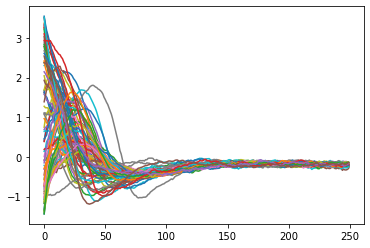

In [7]:
plt.plot(X[:, 0, :, 0]);

In [8]:


model = pm.Model()
with model:
    a_model_star = pm.Normal(name="a_model_star", mu=0.0, sd=1.0)
    a_model = pm.Deterministic(name="a_model", var=-2.0 + 1.0 * a_model_star)
    
    a_coupling_star = pm.Normal(name="a_coupling_star", mu=0.0, sd=1.0)
    a_coupling = pm.Deterministic(name="a_coupling", var=0.1 + 0.05 * a_coupling_star)


In [10]:
from tvb_inversion.pymc3.stats_model_builder import DefaultStochasticPymc3ModelBuilder
model_builder = DefaultStochasticPymc3ModelBuilder(simulator, model=model)
prior = model_builder.set_default_prior(def_std=0.1)
model_builder.configure()
stats_model = model_builder.build()


'a_coupling'

In [ ]:
prior = Pymc3Prior(
    names=["model.a", "coupling.a", "dynamic_noise", "global_noise"], 
    dist=[a_model, a_coupling, dynamic_noise, global_noise]
)

In [ ]:
pymc_model = Pymc3Model(sim=sim, params=prior, model=model)

In [ ]:
pymc_estimator = EstimatorPYMC(stats_model=pymc_model, observation=X)

In [ ]:
draws = 500
tune = 500
cores = 2

In [ ]:
inference_data = pymc_estimator.run_inference(draws, tune, cores, target_accept=0.9)

In [ ]:
init_params = {
    #"a_model": sim.model.a[0],
    "a_coupling": sim.coupling.a[0],
    "noise_gfun": sim.integrator.noise.gfun(None)[0],
    "global_noise": 0.0
}

In [ ]:
pymc_estimator.plot_posterior_samples(init_params)

In [ ]:
posterior_x_obs = inference_data.posterior_predictive.x_obs.values.reshape((cores*draws, *X.shape[:-1]))

In [ ]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [ ]:
pymc_estimator.inference_summary.loc[["a_model", "a_coupling", "global_noise", "noise_gfun"]]

In [ ]:
pymc_estimator.inference_data.to_netcdf(filename="pymc3_data/test1.nc", compress=False)